In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise_generator import GenerateNoise
import qutip as qt

In [50]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-2
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)

In [51]:
trajs = gn.generate_colored_noise()

Sanity Checks (1/f noise):
PSD fit: power = -1.0000, intercept = -4.5598, R² = 0.9990, S0 = 2.094177e-03


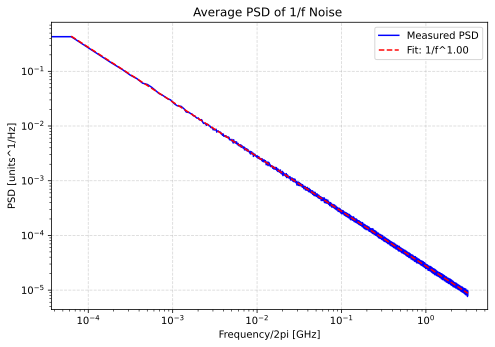

In [52]:
S0 = gn.analyze_noise_psd(trajs)

In [53]:
S0

np.float64(0.0020941774824434394)

In [54]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [[qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points, e_ops=[sigma_x])
    
    # Store the expectation values
    all_expect_values.append(result.expect[0])

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


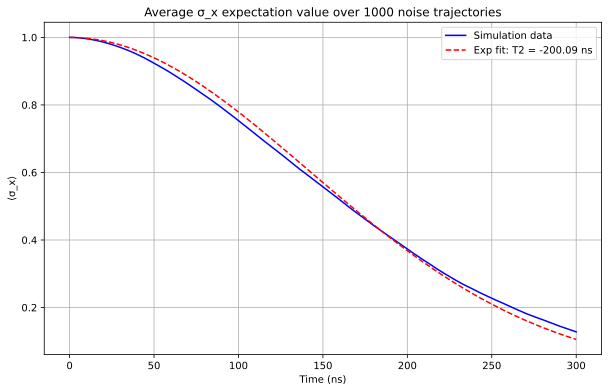

Fitted T2 time = -200.0904 ns


In [55]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay(t, T2):
    return np.exp(-t**2/ T2**2)  # No amplitude parameter

# Fit the data with exponential decay
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_sigmax, p0=[1000])
T2_fit = params[0]

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")


In [56]:
T2_fit

np.float64(-200.09037404203042)

In [59]:
# Theoretical prediction for T2 with 1/f noise
T2_theory = 1/(S0*np.sqrt(2)*np.sqrt(abs(np.log(omega_ir*t_max))))
print(f"Theoretical T2 prediction = {T2_theory:.4f} ns")

Theoretical T2 prediction = 169.4365 ns


In [60]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = noise_matrix
noise = qt.Qobj(sc.noise)


In [61]:
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = qt.Qobj(noise_matrix)


In [62]:
_, state_and_sigmax, get_projector = sc.setup_floquet_system(A , optimal_omega)
U_init , _ = state_and_sigmax(0)
init_state = U_init[:,0]
init_state = qt.Qobj(init_state)

In [63]:
init_state

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.97261966+0.j        ]
 [0.00562134+0.23233466j]]

In [64]:
H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-5.30936513e-03 -1.34800553e-20]
 [-1.34800553e-20  3.86933874e+01]]

In [65]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
# initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
initial_state = init_state
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)], [qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points)
    # Calculate projector averages for each time point
    avg_values = np.zeros((2, len(time_points)))
    for j, t in enumerate(time_points):
        # Get the state at time t
        state_t = result.states[j]
        
        # Get the projector at time t
        U, _ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for both projectors
        avg_values[0, j] = qt.expect(projectors[0], state_t)
        avg_values[1, j] = qt.expect(projectors[1], state_t)
    
    # Store the expectation values for both projectors
    all_expect_values.append(avg_values)

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


In [66]:
avg_expect_values = np.mean(all_expect_values, axis=0)

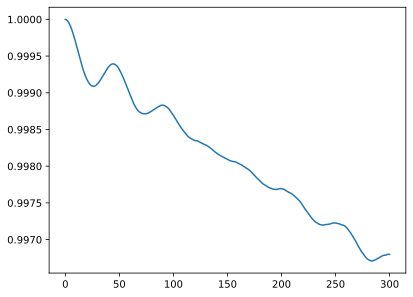

In [67]:
plt.plot(time_points, avg_expect_values[0, :])

In [45]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay_with_oscillation(t, T2, w):
    return np.exp(-t**2 / T2**2) * np.cos(w * t)

# Define envelope function (without oscillation)
def exp_decay_envelope(t, T2):
    return np.exp(-t**2 / T2**2)

# Fit the data with exponential decay
from scipy.optimize import curve_fit
# Initial guess for parameters: T2, w
initial_guess = [1000, 38.693]  # Using w value from context
params, pcov = curve_fit(exp_decay_with_oscillation, time_points, avg_sigmax, p0=initial_guess)
T2_fit, w_fit = params

# Plot the results with just the envelope
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay_envelope(time_points, T2_fit), 'r--', 
         label=f'Envelope: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.